# Winner Determination Problem



In [2]:
import numpy as np
from numpy import savetxt
from numpy import genfromtxt
import random
import operator
from math import ceil
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

In [1]:
class Instance():
  class bidder:
    def __init__(self, items, price):
      self.items = items
      self.price = price

  def __init__(self, num_items, num_bidders, min_items, max_items, max_price):
    self.items = np.arange(num_items)
    self.bidders = np.array([]) 
    
    for i in range(num_bidders):
      self.add(np.unique(np.random.randint(0, num_items, random.randint(min_items, max_items))), random.randint(max_price/2, max_price), self.items) 
    
    self.available_items = np.arange(num_items)
    self.rem_bidders = np.arange(num_bidders)
  
  def add(self, items, price, all_items):
    items = np.array(items)
    if(all(x in all_items for x in items)):
      self.bidders = np.append(self.bidders, self.bidder(items, price))

  def possible_bidders(self):
    poss_bidders = []
    for b in self.bidders:
      if(all(x in self.available_items for x in b.items)):
        poss_bidders.append(np.where(self.bidders == b)[0][0])
    return poss_bidders

  def choose_bidder(self):
    return np.random.choice(self.possible_bidders(), 1)[0]

  def choose_best_bidder_Q(self):
    return self.Q.sum(axis=0).argmax()

  def update(self, bidder, prev_bidder):
    max_index = np.where(self.Q[prev_bidder, ] == np.max(self.Q[prev_bidder, ]))[1]
    if max_index.shape[0] > 1:
      max_index = int(np.random.choice(max_index, size = 1))
    else:
      max_index = int(max_index)
    max_value = self.Q[prev_bidder, max_index] 

    self.Q[prev_bidder, bidder] = self.bidders[bidder].price + self.gamma * max_value

    if (np.max(self.Q) > 0):
      return np.sum(self.Q / np.max(self.Q)*100)
    else:
      return 0

  def train(self, epochs, early=True, gamma=0.4, e=1e-8, stable=10):
    self.Q = np.matrix(np.zeros([len(self.bidders), len(self.bidders)])) 
    self.gamma = gamma
    scores = []
    for i in tqdm(range(epochs)): 
      sum = 0
      self.available_items = self.items
      self.rem_bidders = np.arange(len(self.bidders))
      bidder = self.choose_bidder()
      scores.append(np.sum(self.Q / np.max(self.Q)*100) if (np.max(self.Q) > 0) else 0) 
      prev_bidder = bidder 
      self.rem_bidders = np.array([b for b in self.rem_bidders if b != bidder])
      self.available_items = np.array([i for i in self.available_items if i not in self.bidders[bidder].items])
      while(len(self.possible_bidders()) > 0):
        bidder = self.choose_bidder()
        score = self.update(bidder, prev_bidder)
        prev_bidder = bidder
        self.rem_bidders = np.array([b for b in self.rem_bidders if b != bidder])
        self.available_items = np.array([i for i in self.available_items if i not in self.bidders[bidder].items])
        if(early and self.early_stop(scores, e, ceil(epochs/stable))):
          return scores
        scores.append(score)    
    return scores

  def early_stop(self, scores, e, stable=50):
    if(len(scores) < stable):
      return False
    return ((scores[-stable] - scores[-1])**2 < e)

  def load(self, q_matrix):
    if(len(self.bidders) <= q_matrix.shape[0]):
      self.Q = q_matrix
    else:
      print("Max number of bidders reached")

  def evaluate(self):
    sum = 0
    winners = []
    self.available_items = self.items
    self.rem_bidders = np.arange(len(self.bidders))

    bidder = self.choose_best_bidder_Q()
    winners.append(bidder)
    prev_bidder = bidder
    sum += self.bidders[bidder].price 

    self.rem_bidders = np.array([b for b in self.rem_bidders if b != bidder])
    self.available_items = np.array([i for i in self.available_items if i not in self.bidders[bidder].items])

    while (len(self.possible_bidders()) > 0):
      possible_bidders_scores = {b: self.Q[prev_bidder, b] for b in self.possible_bidders()}
      bidder = max(possible_bidders_scores.items(), key=operator.itemgetter(1))[0]
      winners.append(bidder)
      prev_bidder = bidder
      sum += self.bidders[bidder].price
      self.rem_bidders = np.array([b for b in self.rem_bidders if b != bidder])
      self.available_items = np.array([i for i in self.available_items if i not in self.bidders[bidder].items])
    return winners, sum

  def run(self, epochs=1000, stable=100, early=10):
    history = [] 
    tl = []
    best_solution = [[], 0]
    for i in tqdm(range(epochs)):
      self.available_items = self.items
      self.rem_bidders = np.arange(len(self.bidders))
      solution = [[], 0]
      possible = [b for b in self.possible_bidders() if solution[0]+[b] not in tl]
      possible = sorted(possible, key=lambda x: self.bidders[x].price, reverse=True) 
      while(len(possible) != 0):
        bidder = possible[0] 
        self.rem_bidders = np.array([b for b in self.rem_bidders if b != bidder])
        self.available_items = np.array([i for i in self.available_items if i not in self.bidders[bidder].items])
        solution[0].append(bidder)
        solution[1] += self.bidders[bidder].price
        history.append(best_solution[1])
        tl.append(solution[0])
        if(solution[1] > best_solution[1]):
          best_solution = solution.copy()
          best_i = i
        if(self.early_stop(history, ceil(epochs/stable))): 
          self.available_items = self.items
          self.rem_bidders = np.arange(len(self.bidders))
          possible = [b for b in self.possible_bidders() if solution[0]+[b] not in tl]
          possible = sorted(possible, key=lambda x: self.bidders[x].price, reverse=True) 
          bidder = possible[0] 
          self.rem_bidders = np.array([b for b in self.rem_bidders if b != bidder])
          self.available_items = np.array([i for i in self.available_items if i not in self.bidders[bidder].items])
          solution = [[bidder], self.bidders[bidder].price]
          tl.append(solution[0])
        possible = [b for b in self.possible_bidders() if solution[0]+[b] not in tl]
        possible = sorted(possible, key=lambda x: self.bidders[x].price, reverse=True) 
      if(self.early_stop(history, ceil(epochs/early))):
        return history, best_solution 
    return history, best_solution

# Training for the QL

In [62]:
solver = Instance(4000, 10, 60, 60, 2000) 
early_stoped = solver.train(1500)
regular = solver.train(1500, early=False) 

100%|██████████| 1500/1500 [01:13<00:00, 20.47it/s]


Showcase of the early stop technique

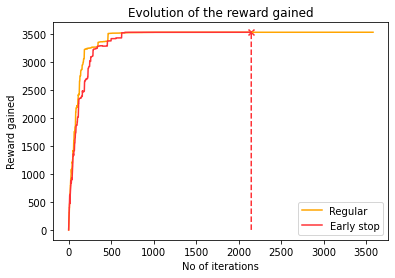

In [90]:
plt.plot(regular, color='orange', label='Regular') 
plt.plot(early_stoped, color='#ff3236', label='Early stop') 
plt.scatter(len(early_stoped), early_stoped[-1], marker='x', color='#ff3236')
plt.plot([len(early_stoped) for i in range(0, ceil(early_stoped[-1]))], range(0, ceil(early_stoped[-1])), color='#ff3236', linestyle='--')
plt.legend()
plt.xlabel('No of iterations') 
plt.ylabel('Reward gained')
plt.title('Evolution of the reward gained')
plt.show() 

## Saving/Loading model

Save

In [ ]:
savetxt('Q_table.csv', solver.Q, delimiter=',') 

In [ ]:
Q_table = genfromtxt('Q_table.csv', delimiter=',') 
Q_table.shape

(500, 500)

Load

In [ ]:
solver = Instance(1000, 400, 80, 2000) 
solver.load(Q_table) 

## Testing model

In [91]:
winners, gain = solver.evaluate()
len(winners), gain 

(3, 3942)

In this case we have 3 winning bids, the total gain is 3942

In [92]:
sold_items = [] 
for w in winners:
  sold_items += solver.bidders[w].items.tolist()
len(sold_items), np.unique(sold_items).size 

(180, 180)

No conflicy between winning bids

# Brute force

In [4]:
def brute_force(sum, winner, av_bidders, av_items):
  for b in av_bidders:
    if (all(x in av_items for x in b.items)):
      brute_force(sum + b.price, winner + 1,
                  np.array([i for i in av_bidders if i != b]), 
                  np.array([i for i in av_items if i not in b.items]))
  gains.append(sum)
  winners.append(winner)

In [5]:
def WDP(av_bidders, av_items): 
  brute_force(0, 0, av_bidders, av_items) 
  return np.max(np.array(winners)[np.where(np.array(gains) == np.max(np.array(gains)))]), np.max(np.array(gains))

In [95]:
gains, winners = [], []
WDP(solver.bidders, solver.items)

(3, 3942)

The solution of this instance contains 3 bidders and the total gain is 3942

## Evaluate the time complexity of the brute force

In [96]:
def evaluate_brute_force(nb_items, min_items, max_items, nb_bidders):
  times = [] 
  for nb_bidders in tqdm(range(1, nb_bidders)):
    solver = Instance(nb_items, nb_bidders, min_items, max_items, 2000) 
    gains, winners = [], []
    start_time = time.time() 
    WDP(solver.bidders, solver.items) 
    times.append((time.time() - start_time)) 
  return times

100%|██████████| 11/11 [07:20<00:00, 40.08s/it]


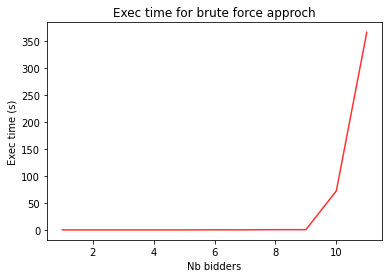

In [102]:
nb_items = 100
min_items = 2
max_items = 5

plt.plot(range(1, 12), evaluate_brute_force(nb_items, min_items, max_items, 12), color='#ff3236')
plt.title('Exec time for brute force approch')
plt.xlabel('Nb bidders') 
plt.ylabel('Exec time (s)')
plt.show()

100%|██████████| 9/9 [02:15<00:00, 15.01s/it]


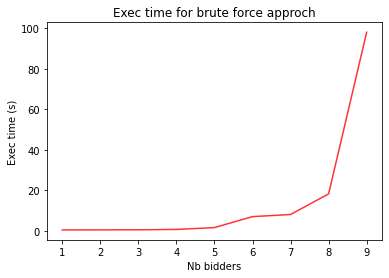

In [104]:
nb_items = 1000 
min_items = 5
max_items = 10

plt.plot(range(1, 10), evaluate_brute_force(nb_items, min_items, max_items, 10), color='#ff3236')
plt.title('Exec time for brute force approch')
plt.xlabel('Nb bidders') 
plt.ylabel('Exec time (s)')
plt.show()

The complexity is clearly exponential with an explosion arround 7-9 bidders

# Q Learning

## Influence of the number of items per bid on the exec time using brute force

100%|██████████| 49/49 [04:26<00:00,  5.44s/it]


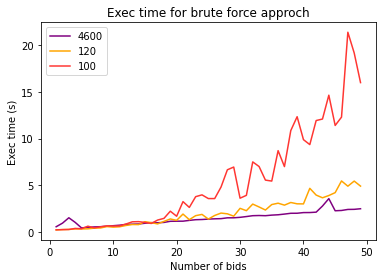

In [ ]:
nb_items = 5000
x = 50
plt.plot(range(1, x), evaluate_brute_force(nb_items, 4600, 4600, x), color='purple', label='4600') 
plt.plot(range(1, x), evaluate_brute_force(nb_items, 120, 120, x), color='orange', label='120') 
plt.plot(range(1, x), evaluate_brute_force(nb_items, 100, 100, x), color='#ff3632', label='100') 
plt.title('Exec time for brute force approch') 
plt.xlabel('Number of bids')
plt.ylabel('Exec time (s)') 
plt.legend()
plt.show()

100%|██████████| 59/59 [08:02<00:00,  8.17s/it]


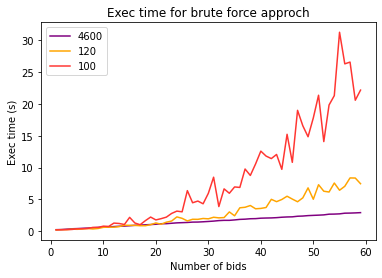

In [ ]:
nb_items = 5000
x = 60
plt.plot(range(1, x), evaluate_brute_force(nb_items, 4600, 4600, x), color='purple', label='4600') 
plt.plot(range(1, x), evaluate_brute_force(nb_items, 120, 120, x), color='orange', label='120') 
plt.plot(range(1, x), evaluate_brute_force(nb_items, 100, 100, x), color='#ff3632', label='100') 
plt.title('Exec time for brute force approch') 
plt.xlabel('Number of bids')
plt.ylabel('Exec time (s)') 
plt.legend()
plt.show()

The exec time is anti-proportional to the nimber of objects per bid

## Influence of the value of gamma

The gamma can be considered as a learning rate, and influences the speed and quality of the convergence of the model

In [133]:
solver = Instance(4000, 15, 50, 50, 2000) 
gains, winners = [], [] 
start_time = time.time() 
w_BF, g_BF = WDP(solver.bidders, solver.items) 
print('BF', w_BF, g_BF, time.time() - start_time)

BF 5 8219 39.82036995887756


 94%|█████████▍| 4721/5000 [06:38<00:23, 11.86it/s]


gamma =  0.9 
 5 7402 398.1462426185608



 15%|█▍        | 730/5000 [01:00<05:54, 12.06it/s]


gamma =  0.4 
 5 8219 60.644914627075195



  7%|▋         | 355/5000 [00:29<06:23, 12.11it/s]


gamma =  0.1 
 5 8219 29.410644054412842



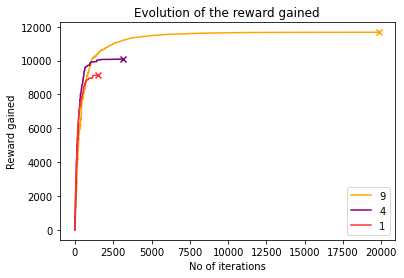

In [134]:
for g, c in zip((9,4,1), ('orange', 'purple', '#ff3236')):
  start_time = time.time() 
  scores = solver.train(5000, gamma=g/10, stable=100) 
  w_Q, g_Q = solver.evaluate() 
  t = time.time() - start_time 
  plt.plot(scores, color=c, label=str(g)) 
  plt.scatter(len(scores), scores[-1], marker='x', color=c)
  print('gamma = ', g/10, '\n', len(w_Q), g_Q, t)
  print()
plt.xlabel('No of iterations') 
plt.ylabel('Reward gained')
plt.title('Evolution of the reward gained')
plt.legend() 
plt.show()

We choose a gamma of 0.4 which gives the best result in the shortest time, with a good convergence

## Validate the results

Number of bidders = 3


  4%|▍         | 263/6000 [00:03<01:14, 77.21it/s]


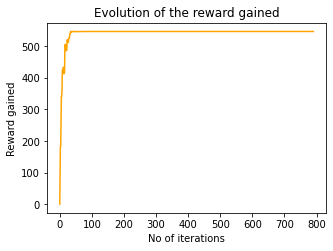

QL: 3 5014 3.689542055130005 
BF: 3 5014 0.1873455047607422

Number of bidders = 4


  6%|▋         | 382/6000 [00:05<01:23, 67.61it/s]


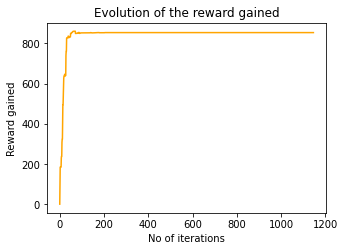

QL: 3 4267 5.846948146820068 
BF: 3 4267 0.09521317481994629

Number of bidders = 5


  6%|▌         | 356/6000 [00:04<01:16, 73.75it/s]


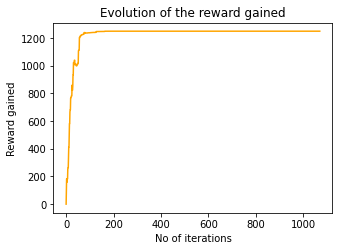

QL: 3 4076 4.998236894607544 
BF: 3 4076 0.13542723655700684

Number of bidders = 6


  8%|▊         | 452/6000 [00:06<01:13, 74.99it/s]


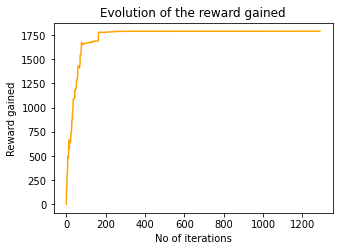

QL: 3 4567 6.202669620513916 
BF: 3 4801 0.17231965065002441

Number of bidders = 7


  8%|▊         | 499/6000 [00:08<01:37, 56.60it/s]


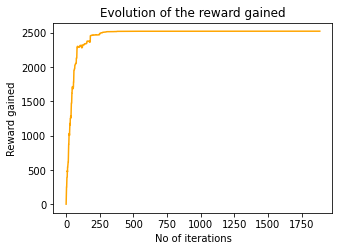

QL: 4 6210 8.9844069480896 
BF: 4 6210 0.711423397064209

Number of bidders = 8


 11%|█▏        | 688/6000 [00:11<01:27, 60.99it/s]


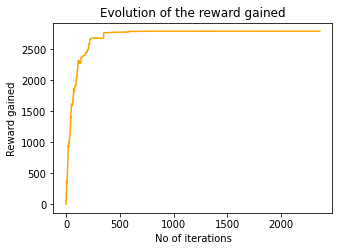

QL: 3 5031 11.452131271362305 
BF: 4 5866 0.5682427883148193

Number of bidders = 9


 11%|█▏        | 686/6000 [00:15<02:00, 43.93it/s]


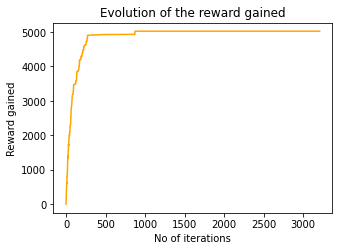

QL: 5 9018 15.801754474639893 
BF: 5 9018 4.1623780727386475

Number of bidders = 10


 12%|█▏        | 703/6000 [00:13<01:44, 50.68it/s]


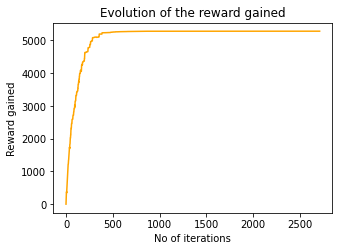

QL: 4 6619 14.159629106521606 
BF: 5 7814 2.215879440307617

Number of bidders = 11


 14%|█▎        | 818/6000 [00:18<01:54, 45.25it/s]


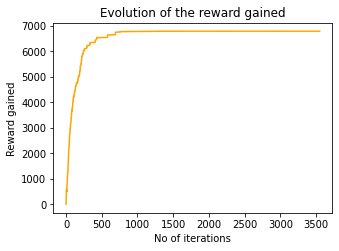

QL: 3 5003 18.25729203224182 
BF: 5 8171 4.924060106277466

Number of bidders = 12


 17%|█▋        | 1035/6000 [00:24<01:55, 43.06it/s]


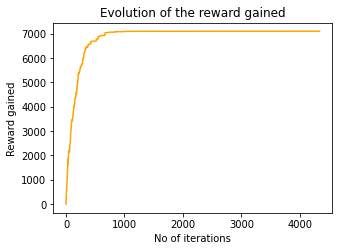

QL: 5 7562 24.22428011894226 
BF: 5 7562 4.810287714004517



In [136]:
time_brute_force = [] 
time_q_learning = []
for nb_bidders in range(3, 13):
  print('Number of bidders =', nb_bidders)
  solver = Instance(1000, nb_bidders, 20, 20, 2000) 
  start_time = time.time() 
  scores = solver.train(6000)
  plt.figure(figsize=(5, 3.5))   
  plt.plot(scores, color='orange') 
  plt.xlabel('No of iterations') 
  plt.ylabel('Reward gained')
  plt.title('Evolution of the reward gained')
  plt.show()
  w_Q, g_Q = solver.evaluate() 
  t_Q = time.time() - start_time
  time_q_learning.append(t_Q) 

  gains, winners = [], []
  start_time = time.time() 
  w_BF, g_BF = WDP(solver.bidders, solver.items) 
  t_BF = time.time() - start_time
  time_brute_force.append(t_BF) 

  print('QL:', len(w_Q), g_Q, t_Q, '\nBF:', w_BF, g_BF, t_BF)
  print()

## Compare the time complexity

Plots of multiple intances of 1000 objects, 10 items per bid and a variable nummber of bidders

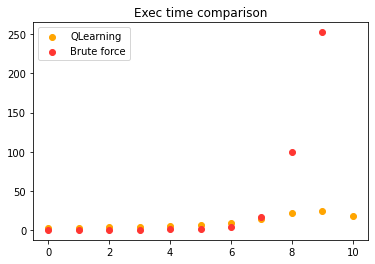

In [ ]:
plt.scatter(range(len(time_q_learning)), time_q_learning, color='orange', label='QLearning')
plt.scatter(range(len(time_brute_force)), time_brute_force, color='#ff3632', label='Brute force')
plt.legend() 
plt.title('Exec time comparison')
plt.show() 

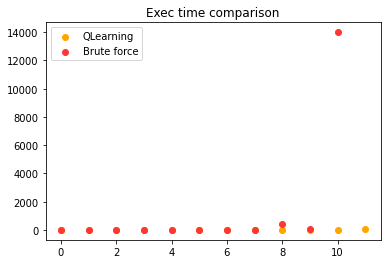

In [ ]:
plt.scatter(range(len(time_q_learning)), time_q_learning, color='orange', label='QLearning')
plt.scatter(range(len(time_brute_force)), time_brute_force, color='#ff3632', label='Brute force')
plt.legend() 
plt.title('Exec time comparison')
plt.show() 

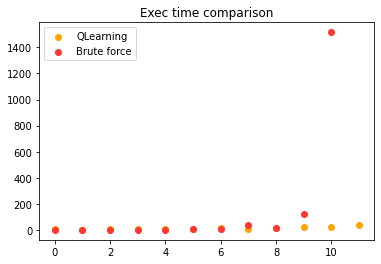

In [ ]:
plt.scatter(range(len(time_q_learning)), time_q_learning, color='orange', label='QLearning')
plt.scatter(range(len(time_brute_force)), time_brute_force, color='#ff3632', label='Brute force')
plt.legend() 
plt.title('Exec time comparison')
plt.show() 

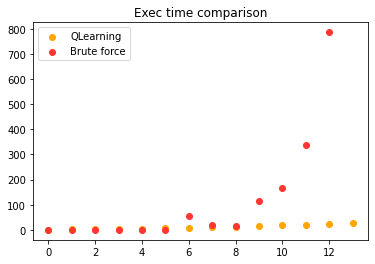

In [ ]:
plt.scatter(range(len(time_q_learning)), time_q_learning, color='orange', label='QLearning')
plt.scatter(range(len(time_brute_force)), time_brute_force, color='#ff3632', label='Brute force')
plt.legend() 
plt.title('Exec time comparison')
plt.show() 

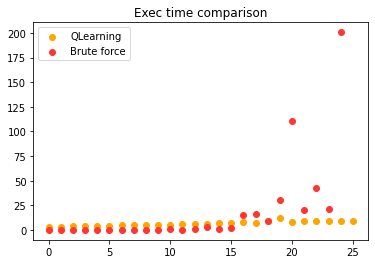

In [ ]:
plt.scatter(range(len(time_q_learning)), time_q_learning, color='orange', label='QLearning')
plt.scatter(range(len(time_brute_force)), time_brute_force, color='#ff3632', label='Brute force')
plt.legend() 
plt.title('Exec time comparison')
plt.show()

## Trivial cases

In [141]:
time_brute_force = []
time_q_learning = []
Q = []
BF = []
for nb_bidders in range(2, 10):
  print('nb_bidders =', nb_bidders)
  solver = Instance(1000, nb_bidders, 10, 10, 2000) 
  start_time = time.time() 
  scores = solver.train(5000)
  w_Q, g_Q = solver.evaluate() 
  Q.append([w_Q, g_Q]) 
  print((time.time() - start_time))
  time_q_learning.append((time.time() - start_time)) 

  gains, winners = [], []
  start_time = time.time() 
  w_BF, g_BF = WDP(solver.bidders, solver.items) 
  BF.append([w_BF, g_BF])
  print((time.time() - start_time))
  time_brute_force.append((time.time() - start_time)) 

  print('\n', len(w_Q), g_Q, w_BF, g_BF, '\n')

nb_bidders = 2


  5%|▌         | 253/5000 [00:02<00:39, 119.19it/s]


2.1429145336151123
0.017817974090576172

 2 2893 2 2893 

nb_bidders = 3


  4%|▍         | 218/5000 [00:02<01:02, 76.16it/s]


2.890317916870117
0.060462236404418945

 3 4143 3 4143 

nb_bidders = 4


  4%|▍         | 216/5000 [00:03<01:24, 56.81it/s]


3.836782455444336
0.2230837345123291

 4 6149 4 6149 

nb_bidders = 5


  6%|▌         | 293/5000 [00:05<01:24, 55.65it/s]


5.2979443073272705
0.41974830627441406

 4 7180 4 7180 

nb_bidders = 6


  7%|▋         | 336/5000 [00:06<01:25, 54.25it/s]


6.225013256072998
0.7136483192443848

 4 5800 4 5800 

nb_bidders = 7


  7%|▋         | 334/5000 [00:07<01:44, 44.76it/s]


7.497458219528198
2.8855669498443604

 5 7542 5 7654 

nb_bidders = 8


  6%|▌         | 305/5000 [00:09<02:19, 33.56it/s]


9.129629850387573
50.43802547454834

 7 10721 7 10721 

nb_bidders = 9


  9%|▊         | 430/5000 [00:13<02:19, 32.77it/s]


13.165719032287598
89.39188122749329

 7 11906 7 11906 



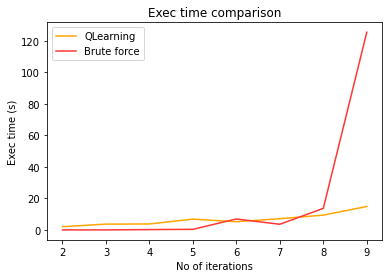

In [138]:
plt.plot(range(2, 10), time_q_learning, color='orange', label='QLearning')
plt.plot(range(2, 10), time_brute_force, color='#ff3632', label='Brute force')
plt.legend() 
plt.xlabel('No of iterations') 
plt.ylabel('Exec time (s)')
plt.title('Exec time comparison')
plt.show() 

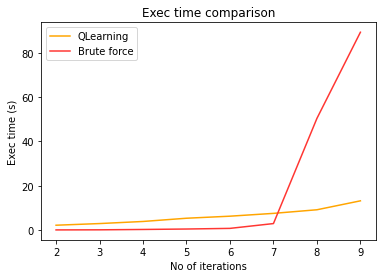

In [142]:
plt.plot(range(2, 10), time_q_learning, color='orange', label='QLearning')
plt.plot(range(2, 10), time_brute_force, color='#ff3632', label='Brute force')
plt.legend() 
plt.xlabel('No of iterations') 
plt.ylabel('Exec time (s)')
plt.title('Exec time comparison')
plt.show() 

For trivial cases (2 to 7 bidders) the brute force is better cause the number of possibilities is really small, but then we can observe the explosion in the exec time

# Tabu search

## Early stop

In [ ]:
solver = Instance(4000, 10, 60, 60, 2000) 
early_stoped, _ = solver.run(1500, early=10)
regular, _ = solver.run(1500, early=-1) 

100%|██████████| 1500/1500 [00:07<00:00, 190.30it/s]


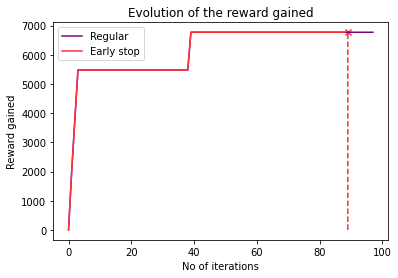

In [ ]:
plt.plot(regular, color='purple', label='Regular') 
plt.plot(early_stoped, color='#ff3236', label='Early stop') 
plt.scatter(len(early_stoped), early_stoped[-1], marker='x', color='#ff3236')
plt.plot([len(early_stoped) for i in range(0, ceil(early_stoped[-1]))], range(0, ceil(early_stoped[-1])), color='#ff3236', linestyle='--')
plt.legend()
plt.xlabel('No of iterations') 
plt.ylabel('Reward gained')
plt.title('Evolution of the reward gained')
plt.show() 

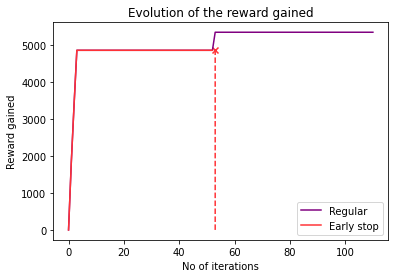

In [ ]:
plt.plot(regular, color='purple', label='Regular') 
plt.plot(early_stoped, color='#ff3236', label='Early stop') 
plt.scatter(len(early_stoped), early_stoped[-1], marker='x', color='#ff3236')
plt.plot([len(early_stoped) for i in range(0, ceil(early_stoped[-1]))], range(0, ceil(early_stoped[-1])), color='#ff3236', linestyle='--')
plt.legend()
plt.xlabel('No of iterations') 
plt.ylabel('Reward gained')
plt.title('Evolution of the reward gained')
plt.show() 

Example of a bad choice for the value of the early stop, we ended the execution just before we found a better solution

## Validate the results

In [153]:
solvers = (Instance(100, 15, 10, 20, 2000), 
          Instance(100, 15, 50, 50, 2000), 
          Instance(1000, 15, 100, 100, 2000), 
          Instance(4000, 13, 50, 50, 2000), 
          Instance(5000, 13, 50, 100, 2000),
          Instance(5000, 13, 100, 100, 2000),
          Instance(5000, 13, 200, 200, 2000),
          Instance(1000, 13, 100, 100, 2000))

time_brute_force = [] 
time_q_learning = []
time_tabu = []
           
for solver in solvers:
  print('Instance: ', len(solver.items), len(solver.bidders))
  start_time = time.time() 
  scores = solver.train(5000)
  w_Q, g_Q = solver.evaluate()
  t_Q = time.time() - start_time
  time_q_learning.append(t_Q)

  gains, winners = [], []
  start_time = time.time() 
  w_BF, g_BF = WDP(solver.bidders, solver.items) 
  t_BF = time.time() - start_time
  time_brute_force.append(t_BF)

  start_time = time.time() 
  history, solution = solver.run(epochs=1000, stable=10, early=10)
  t_TS = time.time() - start_time
  time_tabu.append(t_TS)
  print('QL', len(w_Q), g_Q, t_Q)
  print('BF', w_BF, g_BF, t_BF)
  print('TS', len(solution[0]), solution[1], t_TS)
  print() 

Instance:  100 15


100%|██████████| 1000/1000 [00:01<00:00, 935.94it/s]


QL 2 2651 3.286970376968384
BF 2 3743 0.017493247985839844
TS 2 3743 1.0748662948608398

Instance:  100 15


100%|██████████| 1000/1000 [00:02<00:00, 434.38it/s]


QL 1 1752 14.480987787246704
BF 1 1961 0.011209964752197266
TS 1 1961 2.309952735900879

Instance:  1000 15


100%|██████████| 1000/1000 [00:06<00:00, 147.15it/s]


QL 1 1873 55.82165288925171
BF 1 1994 0.06938838958740234
TS 1 1994 6.804931163787842

Instance:  4000 13


  1%|▏         | 14/1000 [00:01<01:41,  9.74it/s]


QL 4 6436 136.3243534564972
BF 5 7906 31.19589877128601
TS 5 7906 1.4433717727661133

Instance:  5000 13


  2%|▏         | 19/1000 [00:01<01:24, 11.66it/s]


QL 3 5178 107.624431848526
BF 4 5965 6.726171493530273
TS 3 5178 1.6364870071411133

Instance:  5000 13


  3%|▎         | 30/1000 [00:01<00:47, 20.41it/s]


QL 2 3829 70.96028137207031
BF 2 3829 0.8093972206115723
TS 2 3829 1.4746744632720947

Instance:  5000 13


100%|██████████| 1000/1000 [00:16<00:00, 59.78it/s]


QL 1 1423 200.50732231140137
BF 1 1968 0.2820003032684326
TS 1 1968 16.73452353477478

Instance:  1000 13


100%|██████████| 1000/1000 [00:05<00:00, 178.84it/s]

QL 1 1660 52.60422730445862
BF 1 1938 0.0624079704284668
TS 1 1938 5.596765518188477



## Compare the time complexity

### 1000, 10

In [190]:
time_brute_force = [] 
time_q_learning = []
time_tabu = []
           
for nb_bidders in range(2, 10):
  solver = Instance(1000, nb_bidders, 10, 10, 2000)
  print('Number of bidders =', nb_bidders)
  start_time = time.time() 
  scores = solver.train(5000)
  w_Q, g_Q = solver.evaluate()
  t_Q = time.time() - start_time
  time_q_learning.append(t_Q)

  start_time = time.time() 
  history, solution = solver.run(epochs=1000, stable=10, early=10)
  t_TS = time.time() - start_time
  time_tabu.append(t_TS)  

  gains, winners = [], []
  start_time = time.time() 
  w_BF, g_BF = WDP(solver.bidders, solver.items) 
  t_BF = time.time() - start_time
  time_brute_force.append(t_BF)

  print('QL', len(w_Q), g_Q, t_Q)
  print('BF', w_BF, g_BF, t_BF)
  print('TS', len(solution[0]), solution[1], t_TS)
  print()

Number of bidders = 2


100%|██████████| 1000/1000 [00:00<00:00, 6616.91it/s]


QL 2 2534 2.506373167037964
BF 2 2534 0.01917409896850586
TS 2 2534 0.15710020065307617

Number of bidders = 3


100%|██████████| 1000/1000 [00:00<00:00, 4383.83it/s]


QL 2 3154 3.0819385051727295
BF 2 3154 0.028512239456176758
TS 2 3154 0.2360553741455078

Number of bidders = 4


  2%|▏         | 22/1000 [00:00<00:10, 95.30it/s] 


QL 3 5170 3.55969500541687
BF 3 5170 0.09606623649597168
TS 3 5170 0.23893284797668457

Number of bidders = 5


  2%|▏         | 24/1000 [00:00<00:13, 69.97it/s]


QL 3 4738 5.4098899364471436
BF 4 5177 0.2713460922241211
TS 4 5177 0.35164904594421387

Number of bidders = 6


  1%|          | 12/1000 [00:00<00:23, 42.56it/s]


QL 5 6964 7.158921241760254
BF 5 6964 2.005580425262451
TS 5 6964 0.289719820022583

Number of bidders = 7


  1%|          | 10/1000 [00:00<00:29, 33.70it/s]


QL 6 8453 8.155427932739258
BF 6 8453 7.739725351333618
TS 6 8453 0.30908775329589844

Number of bidders = 8


  1%|          | 12/1000 [00:00<00:23, 42.08it/s]


QL 5 8178 12.122605562210083
BF 6 9081 15.532028913497925
TS 5 8178 0.29688286781311035

Number of bidders = 9


  1%|▏         | 14/1000 [00:00<00:24, 40.05it/s]


QL 5 8631 10.813027620315552
BF 6 9767 20.52382755279541
TS 5 8814 0.3582916259765625



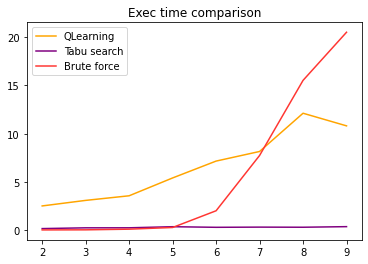

In [191]:
plt.plot(range(2, 10), time_q_learning, color='orange', label='QLearning')
plt.plot(range(2, 10), time_tabu, color='purple', label='Tabu search')
plt.plot(range(2, 10), time_brute_force, color='#ff3632', label='Brute force')
plt.legend() 
plt.title('Exec time comparison')
plt.show() 

In [6]:
time_brute_force = [] 
time_q_learning = []
time_tabu = []
           
for nb_bidders in range(2, 10):
  solver = Instance(1000, nb_bidders, 10, 10, 2000)
  print('Number of bidders =', nb_bidders)
  start_time = time.time() 
  scores = solver.train(5000)
  w_Q, g_Q = solver.evaluate()
  t_Q = time.time() - start_time
  time_q_learning.append(t_Q)

  start_time = time.time() 
  history, solution = solver.run(epochs=1000, stable=10, early=10)
  t_TS = time.time() - start_time
  time_tabu.append(t_TS)  

  gains, winners = [], []
  start_time = time.time() 
  w_BF, g_BF = WDP(solver.bidders, solver.items) 
  t_BF = time.time() - start_time
  time_brute_force.append(t_BF)

  print('QL', len(w_Q), g_Q, t_Q)
  print('BF', w_BF, g_BF, t_BF)
  print('TS', len(solution[0]), solution[1], t_TS)
  print()

Number of bidders = 2


100%|██████████| 1000/1000 [00:00<00:00, 6709.09it/s]


QL 2 3310 2.321518659591675
BF 2 3310 0.014334917068481445
TS 2 3310 0.16499614715576172

Number of bidders = 3


100%|██████████| 1000/1000 [00:00<00:00, 3150.21it/s]


QL 3 4146 2.785090208053589
BF 3 4146 0.057259559631347656
TS 3 4146 0.32396364212036133

Number of bidders = 4


  2%|▏         | 17/1000 [00:00<00:13, 75.32it/s]


QL 4 7133 3.2589709758758545
BF 4 7133 0.2269141674041748
TS 4 7133 0.23255515098571777

Number of bidders = 5


  2%|▏         | 17/1000 [00:00<00:13, 73.91it/s]


QL 4 5622 5.980644226074219
BF 4 5622 0.4051837921142578
TS 4 5622 0.23679161071777344

Number of bidders = 6


  1%|          | 10/1000 [00:00<00:27, 36.37it/s]


QL 6 8315 5.441140413284302
BF 6 8315 6.56373143196106
TS 6 8315 0.2826414108276367

Number of bidders = 7


  1%|          | 10/1000 [00:00<00:58, 17.04it/s]


QL 6 9275 9.403022527694702
BF 6 9275 13.18211841583252
TS 6 9275 0.61171555519104

Number of bidders = 8


  1%|          | 10/1000 [00:00<00:29, 33.85it/s]


QL 6 8791 9.528605461120605
BF 6 8886 17.976580381393433
TS 6 8791 0.30055880546569824

Number of bidders = 9


  1%|          | 10/1000 [00:00<00:28, 34.75it/s]


QL 6 9258 13.506158828735352
BF 6 9258 41.328513860702515
TS 6 9258 0.2983114719390869



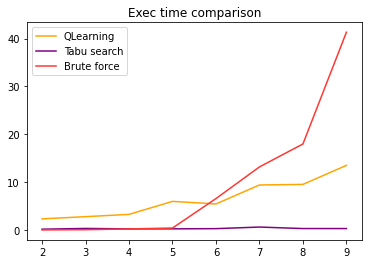

In [7]:
plt.plot(range(2, 10), time_q_learning, color='orange', label='QLearning')
plt.plot(range(2, 10), time_tabu, color='purple', label='Tabu search')
plt.plot(range(2, 10), time_brute_force, color='#ff3632', label='Brute force')
plt.legend() 
plt.title('Exec time comparison')
plt.show() 

### Other tests

In [24]:
time_brute_force = [] 
time_q_learning = []
time_tabu = []

for nb_bidders in range(4, 10):
  solver = Instance(5000, nb_bidders, 20, 20, 2000)
  print('Number of bidders =', nb_bidders)
  start_time = time.time() 
  scores = solver.train(5000)
  w_Q, g_Q = solver.evaluate()
  t_Q = time.time() - start_time
  time_q_learning.append(t_Q)

  start_time = time.time() 
  history, solution = solver.run(epochs=1000, stable=10, early=10)
  t_TS = time.time() - start_time
  time_tabu.append(t_TS)  

  gains, winners = [], []
  start_time = time.time() 
  w_BF, g_BF = WDP(solver.bidders, solver.items) 
  t_BF = time.time() - start_time
  time_brute_force.append(t_BF)

  print('QL', len(w_Q), g_Q, t_Q)
  print('BF', w_BF, g_BF, t_BF)
  print('TS', len(solution[0]), solution[1], t_TS)
  print()

Number of bidders = 4


  2%|▏         | 17/1000 [00:01<01:03, 15.58it/s]


QL 4 6162 30.75038194656372
BF 4 6162 1.1209609508514404
TS 4 6162 1.0996336936950684

Number of bidders = 5


  2%|▏         | 16/1000 [00:01<01:10, 14.01it/s]


QL 4 6696 20.933058500289917
BF 4 6696 1.3163707256317139
TS 4 6696 1.1511454582214355

Number of bidders = 6


  1%|          | 10/1000 [00:01<02:11,  7.53it/s]


QL 6 9426 25.383469820022583
BF 6 9426 33.95903539657593
TS 6 9426 1.3347561359405518

Number of bidders = 7


  1%|          | 10/1000 [00:01<02:16,  7.27it/s]


QL 6 9569 37.98655724525452
BF 6 9569 61.401121854782104
TS 6 9569 1.3815529346466064

Number of bidders = 8


  1%|          | 10/1000 [00:01<02:14,  7.34it/s]


QL 6 9958 47.264543533325195
BF 6 9958 114.16300177574158
TS 6 9958 1.3688416481018066

Number of bidders = 9


  1%|          | 7/1000 [00:01<03:31,  4.69it/s]


QL 8 11230 54.33029389381409
BF 8 11230 2047.664517402649
TS 8 11230 1.5015687942504883



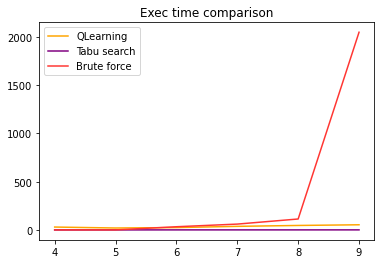

In [25]:
plt.plot(range(4, 10), time_q_learning, color='orange', label='QLearning')
plt.plot(range(4, 10), time_tabu, color='purple', label='Tabu search')
plt.plot(range(4, 10), time_brute_force, color='#ff3632', label='Brute force')
plt.legend() 
plt.title('Exec time comparison')
plt.show() 

In [42]:
time_brute_force = [] 
time_q_learning = []
time_tabu = []

for nb_bidders in range(2, 9):
  solver = Instance(6000, nb_bidders, 10, 10, 2000)
  print('Number of bidders =', nb_bidders)
  start_time = time.time() 
  scores = solver.train(5000)
  w_Q, g_Q = solver.evaluate()
  t_Q = time.time() - start_time
  time_q_learning.append(t_Q)

  start_time = time.time() 
  history, solution = solver.run(epochs=1000, stable=10, early=10)
  t_TS = time.time() - start_time
  time_tabu.append(t_TS)  

  gains, winners = [], []
  start_time = time.time() 
  w_BF, g_BF = WDP(solver.bidders, solver.items) 
  t_BF = time.time() - start_time
  time_brute_force.append(t_BF)

  print('QL', len(w_Q), g_Q, t_Q)
  print('BF', w_BF, g_BF, t_BF)
  print('TS', len(solution[0]), solution[1], t_TS)
  print()

Number of bidders = 2


100%|██████████| 1000/1000 [00:00<00:00, 3370.06it/s]


QL 2 2577 14.377592325210571
BF 2 2577 0.08855795860290527
TS 2 2577 0.3044755458831787

Number of bidders = 3


100%|██████████| 1000/1000 [00:01<00:00, 978.58it/s]


QL 3 3826 16.944859743118286
BF 3 3826 0.3201792240142822
TS 3 3826 1.0298058986663818

Number of bidders = 4


  2%|▏         | 17/1000 [00:01<01:15, 13.04it/s]


QL 4 5769 18.295287609100342
BF 4 5769 1.364457368850708
TS 4 5769 1.3103678226470947

Number of bidders = 5


  2%|▏         | 17/1000 [00:01<01:16, 12.93it/s]


QL 4 5911 30.401042938232422
BF 4 5911 2.363219976425171
TS 4 5911 1.3226056098937988

Number of bidders = 6


  1%|          | 10/1000 [00:01<02:35,  6.37it/s]


QL 6 10004 28.59037756919861
BF 6 10004 40.868035316467285
TS 6 10004 1.5756478309631348

Number of bidders = 7


  1%|          | 8/1000 [00:01<03:23,  4.87it/s]


QL 7 10599 38.93727397918701
BF 7 10599 283.04005765914917
TS 7 10599 1.6495585441589355

Number of bidders = 8


  1%|          | 8/1000 [00:01<03:30,  4.70it/s]


QL 7 11146 44.25016450881958
BF 7 11146 317.4080412387848
TS 7 11146 1.7072510719299316



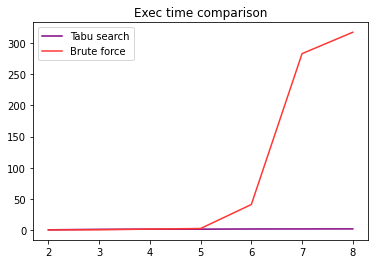

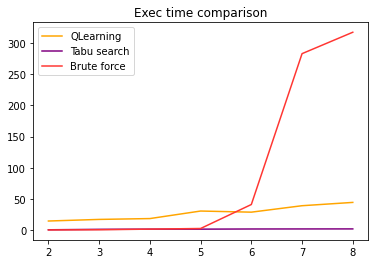

In [43]:
plt.plot(range(2, 9), time_tabu, color='purple', label='Tabu search')
plt.plot(range(2, 9), time_brute_force, color='#ff3632', label='Brute force')
plt.legend() 
plt.title('Exec time comparison')
plt.show() 
plt.plot(range(2, 9), time_q_learning, color='orange', label='QLearning')
plt.plot(range(2, 9), time_tabu, color='purple', label='Tabu search')
plt.plot(range(2, 9), time_brute_force, color='#ff3632', label='Brute force')
plt.legend() 
plt.title('Exec time comparison')
plt.show() 

### Comparaison of exec time with the brute force

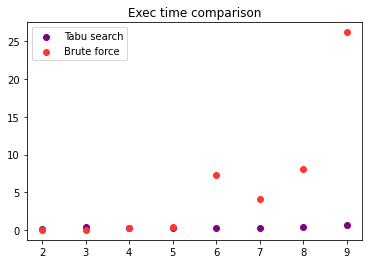

In [ ]:
plt.scatter(range(2, 10), time_tabu, color='purple', label='Tabu search')
plt.scatter(range(2, 10), time_brute_force, color='#ff3632', label='Brute force')
plt.legend() 
plt.title('Exec time comparison')
plt.show() 

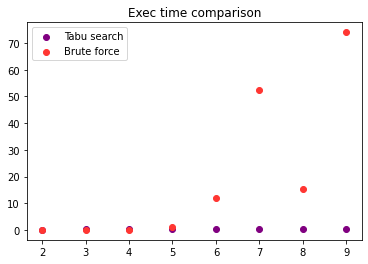

In [ ]:
plt.scatter(range(2, 10), time_tabu, color='purple', label='Tabu search')
plt.scatter(range(2, 10), time_brute_force, color='#ff3632', label='Brute force')
plt.legend() 
plt.title('Exec time comparison')
plt.show() 

## Trivial cases

In [ ]:
time_brute_force = []
time_tabu = []
TS = []
BF = []
for nb_bidders in range(2, 10):
  print('nb_bidders =', nb_bidders)
  solver = Instance(1000, nb_bidders, 10, 10, 2000) 

  start_time = time.time() 
  history, solution = solver.run(epochs=1000, stable=10, early=10)
  t_TS = time.time() - start_time
  TS.append(solution)
  print(t_TS)
  time_tabu.append(t_TS)  

  gains, winners = [], []
  start_time = time.time() 
  w_BF, g_BF = WDP(solver.bidders, solver.items) 
  BF.append([w_BF, g_BF])
  print((time.time() - start_time))
  time_brute_force.append((time.time() - start_time)) 

  print('\n', len(solution[0]), solution[1], w_BF, g_BF, '\n')

nb_bidders = 2


100%|██████████| 1000/1000 [00:00<00:00, 5977.76it/s]

0.17801189422607422
0.016940832138061523

 2 2690 2

 2690 

nb_bidders = 3


100%|██████████| 1000/1000 [00:00<00:00, 2545.92it/s]


0.4060385227203369
0.0715029239654541

 3 3533 3 3533 

nb_bidders = 4


100%|██████████| 1000/1000 [00:00<00:00, 2916.13it/s]


0.3535497188568115
0.04989767074584961

 2 3542 2 3542 

nb_bidders = 5


  2%|▏         | 22/1000 [00:00<00:11, 82.29it/s]


0.28258585929870605
0.16282939910888672

 3 5382 3 5382 

nb_bidders = 6


  1%|          | 10/1000 [00:00<00:30, 32.36it/s]


0.31885266304016113
8.402277946472168

 6 8936 6 8936 

nb_bidders = 7


  1%|          | 12/1000 [00:00<00:27, 35.89it/s]


0.3459479808807373
4.149357557296753

 5 7861 5 7861 

nb_bidders = 8


  1%|          | 8/1000 [00:00<00:42, 23.29it/s]


0.35245203971862793
63.16314172744751

 7 9942 7 9942 

nb_bidders = 9


  1%|          | 10/1000 [00:00<00:32, 30.21it/s]


0.34424710273742676
32.28654408454895

 6 9050 6 9050 



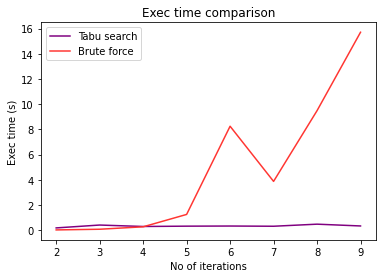

In [ ]:
plt.plot(range(2, 10), time_tabu, color='purple', label='Tabu search')
plt.plot(range(2, 10), time_brute_force, color='#ff3632', label='Brute force')
plt.legend() 
plt.xlabel('No of iterations') 
plt.ylabel('Exec time (s)')
plt.title('Exec time comparison')
plt.show() 

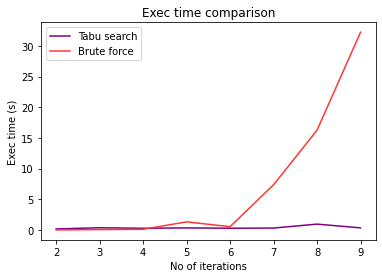

In [ ]:
plt.plot(range(2, 10), time_tabu, color='purple', label='Tabu search')
plt.plot(range(2, 10), time_brute_force, color='#ff3632', label='Brute force')
plt.legend() 
plt.xlabel('No of iterations') 
plt.ylabel('Exec time (s)')
plt.title('Exec time comparison')
plt.show() 

# Advanced tests

We now compare Tabu search and Q learning on big and complex instanes

In [184]:
time_q_learning = []
time_tabu = []

for nb_bidders in range(4, 30):
  solver = Instance(1000, nb_bidders, 40, 50, 2000)
  print('Number of bidders =', nb_bidders)
  start_time = time.time() 
  scores = solver.train(5000) 
  w_Q, g_Q = solver.evaluate()
  t_Q = time.time() - start_time
  time_q_learning.append(t_Q)

  start_time = time.time() 
  history, solution = solver.run(epochs=1000, stable=10, early=10)
  t_TS = time.time() - start_time
  time_tabu.append(t_TS)  

  print('QL', len(w_Q), g_Q, t_Q)
  print('TS', len(solution[0]), solution[1], t_TS)
  print()

Number of bidders = 4


100%|██████████| 1000/1000 [00:00<00:00, 1153.96it/s]


QL 2 3200 3.024413824081421
TS 2 3200 0.8744332790374756

Number of bidders = 5


100%|██████████| 1000/1000 [00:00<00:00, 1014.43it/s]


QL 2 2348 3.6970646381378174
TS 2 2348 0.9935603141784668

Number of bidders = 6


100%|██████████| 1000/1000 [00:01<00:00, 737.37it/s]


QL 2 3006 6.039831161499023
TS 2 3313 1.3673021793365479

Number of bidders = 7


100%|██████████| 1000/1000 [00:01<00:00, 645.20it/s]


QL 2 3636 5.447965621948242
TS 2 3636 1.5565767288208008

Number of bidders = 8


100%|██████████| 1000/1000 [00:01<00:00, 557.63it/s]


QL 2 3548 4.474369525909424
TS 2 3548 1.8036096096038818

Number of bidders = 9


100%|██████████| 1000/1000 [00:02<00:00, 478.48it/s]


QL 2 3679 7.874255418777466
TS 3 5057 2.1017069816589355

Number of bidders = 10


  3%|▎         | 27/1000 [00:00<00:11, 81.30it/s]


QL 3 4598 8.496084451675415
TS 3 4598 0.34216856956481934

Number of bidders = 11


  3%|▎         | 30/1000 [00:00<00:12, 77.57it/s]


QL 2 3601 13.051689624786377
TS 3 4818 0.39583539962768555

Number of bidders = 12


100%|██████████| 1000/1000 [00:02<00:00, 369.21it/s]


QL 2 3504 9.37776231765747
TS 2 3504 2.723635673522949

Number of bidders = 13


  3%|▎         | 30/1000 [00:01<00:38, 25.00it/s]


QL 2 3554 16.396984338760376
TS 2 3554 1.2116291522979736

Number of bidders = 14


  3%|▎         | 28/1000 [00:00<00:13, 72.44it/s]


QL 3 4958 14.721236944198608
TS 3 4958 0.40326786041259766

Number of bidders = 15


  3%|▎         | 31/1000 [00:00<00:11, 82.88it/s]


QL 2 3276 18.13275718688965
TS 2 3665 0.3841092586517334

Number of bidders = 16


  3%|▎         | 33/1000 [00:00<00:12, 78.01it/s]


QL 2 3727 23.07102084159851
TS 2 3727 0.4330627918243408

Number of bidders = 17


  2%|▏         | 22/1000 [00:00<00:17, 57.17it/s]


QL 3 5832 26.39755892753601
TS 3 5832 0.3971443176269531

Number of bidders = 18


  3%|▎         | 32/1000 [00:00<00:15, 63.23it/s]


QL 2 3195 33.59718704223633
TS 3 4493 0.5173296928405762

Number of bidders = 19


  3%|▎         | 31/1000 [00:00<00:14, 68.32it/s]


QL 2 3337 33.711878061294556
TS 3 4269 0.4634387493133545

Number of bidders = 20


  2%|▏         | 24/1000 [00:00<00:16, 59.35it/s]


QL 2 3343 42.312952756881714
TS 3 5332 0.4148736000061035

Number of bidders = 21


  5%|▍         | 46/1000 [00:00<00:14, 65.52it/s]


QL 2 3883 36.534862756729126
TS 3 4857 0.7157561779022217

Number of bidders = 22


  3%|▎         | 33/1000 [00:00<00:14, 65.37it/s]


QL 2 3739 40.864224672317505
TS 3 5080 0.5164234638214111

Number of bidders = 23


  4%|▎         | 37/1000 [00:00<00:16, 59.18it/s]


QL 2 3471 61.94919037818909
TS 3 4948 0.6351306438446045

Number of bidders = 24


  3%|▎         | 29/1000 [00:00<00:17, 55.92it/s]


QL 3 4600 49.80312180519104
TS 3 4600 0.5295038223266602

Number of bidders = 25


  3%|▎         | 31/1000 [00:00<00:17, 55.53it/s]


QL 2 3863 60.84755182266235
TS 3 4568 0.5691301822662354

Number of bidders = 26


  3%|▎         | 33/1000 [00:00<00:16, 58.12it/s]


QL 3 4145 68.77642607688904
TS 3 4535 0.5780987739562988

Number of bidders = 27


  4%|▍         | 41/1000 [00:00<00:16, 56.58it/s]


QL 2 3443 84.88167548179626
TS 3 4800 0.7375633716583252

Number of bidders = 28


  3%|▎         | 30/1000 [00:00<00:32, 30.29it/s]


QL 3 4532 76.32192921638489
TS 3 5047 1.0004971027374268

Number of bidders = 29


  5%|▍         | 49/1000 [00:00<00:17, 55.40it/s]

QL 3 4969 117.85117197036743
TS 3 4969 0.893423318862915



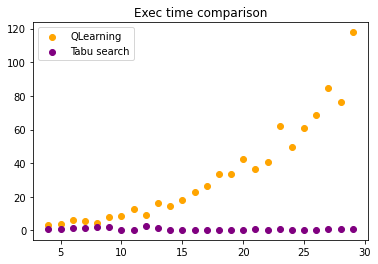

In [185]:
plt.scatter(range(4, 30), time_q_learning, color='orange', label='QLearning')
plt.scatter(range(4, 30), time_tabu, color='purple', label='Tabu search')
plt.legend() 
plt.title('Exec time comparison')
plt.show() 

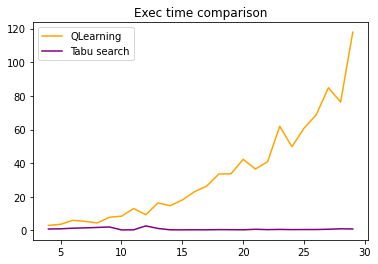

In [186]:
plt.plot(range(4, 30), time_q_learning, color='orange', label='QLearning')
plt.plot(range(4, 30), time_tabu, color='purple', label='Tabu search')
plt.legend() 
plt.title('Exec time comparison')
plt.show() 